# Importing Libraries with Alias

In [1]:
import os
import torch
import numpy as np
import torch.nn as nn
from torch.functional import F
from torch.utils.data import DataLoader,Dataset
import cv2
from PIL import Image
from torchvision.transforms import transforms

### Mounting Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Defining File Paths

In [2]:
path_train ='drive/MyDrive/training_set/'
path_mask = 'drive/MyDrive/training_set_mask/'
path_test = 'drive/MyDrive/test_set/'
img_files = sorted(os.listdir(os.path.join(path_train)))
mask_files = sorted(os.listdir(os.path.join(path_mask)))
test_files = sorted(os.listdir(os.path.join(path_test)))

In [ ]:
len(test_files)

335

### Defining DataLoader Function

In [3]:
class SegmentationDataset(Dataset):
    def __init__(self, imagePaths, maskPaths, transforms,padding):
        # store the image and mask filepaths, and augmentation transforms
        self.imagePaths = imagePaths
        self.maskPaths = maskPaths
        self.transforms = transforms
        self.padding = padding
    
    def __len__(self):
        
        # return the number of total samples contained in the dataset
        return len(self.imagePaths)
    
    def __getitem__(self, idx):
        # grab the image path from the current index
        
        image = cv2.imread("drive/MyDrive/training_set/"+self.imagePaths[idx],0)
        mask = cv2.imread("drive/MyDrive/training_set_mask/"+self.maskPaths[idx],0)
        mask_contour= cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(mask,mask_contour[0],0,255, -1)
        # check to see if we are applying any transformations
        if self.transforms is not None:
            
            # apply the transformations to both image and its mask
            image = self.transforms(image)
            mask = self.transforms(mask)
            image = F.pad(image, pad=(0,0,2,2), mode='constant', value=0)
            mask = F.pad(mask, pad=(0,0,2,2), mode='constant', value=0)
            
            # return a tuple of the image and its mask
        return (image, mask)

In [4]:
class TestDataset(Dataset):
    def __init__(self,testPaths,transforms,padding):
        self.testPaths = testPaths
        self.transforms = transforms
        self.padding = padding

    def __len__(self):
        
        # return the number of total samples contained in the dataset
        return len(self.testPaths)

    def __getitem__(self, idx):
        # grab the image path from the current index
        
        test = cv2.imread("drive/MyDrive/test_set/"+self.testPaths[idx],0)
        # check to see if we are applying any transformations
        if self.transforms is not None:
            
            # apply the transformations to both image and its mask
            test = self.transforms(test)
            test = F.pad(test, pad=(0,0,2,2), mode='constant', value=0)   
            # return a tuple of the image and its mask
        return test

In [55]:
def DataLoading(img_files,mask_files,test_files,val_size,batch_size):
    transform = transforms.Compose([transforms.ToPILImage(),transforms.Resize((540,800)),transforms.ToTensor()])

    # create the train and test datasets
    train_size  = len(img_files) - val_size
    trainDS = SegmentationDataset(imagePaths=img_files[:train_size], 
                                  maskPaths=mask_files[:train_size],
                                  transforms=transform,padding=2)

    valDS = SegmentationDataset(imagePaths=img_files[train_size:], 
                                maskPaths=mask_files[train_size:],
                                transforms=transform,padding=2)

    testDS = TestDataset(testPaths = test_files,transforms = transform,padding=2)
    print(f"[INFO] found {len(trainDS)} examples in the training set...")

    print(f"[INFO] found {len(valDS)} examples in the val set...")

    print(f"[INFO] found {len(testDS)} examples in the val set...")
    # create the training and test data loaders
    trainLoader = DataLoader(trainDS, shuffle=True,batch_size=batch_size, pin_memory=True,
                             num_workers=os.cpu_count())

    valLoader = DataLoader(valDS, shuffle=False,batch_size=batch_size, pin_memory=True,
                           num_workers=os.cpu_count())
    
    testLoader = DataLoader(testDS,shuffle=False,batch_size=batch_size,pin_memory=True,num_workers=os.cpu_count())
    
    return trainLoader,valLoader,testLoader

### Choosing th device (CPU/GPU)

In [6]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

### Building Model

In [7]:
def dice_coefficient(pred, target, smooth = 1.):
    # Flatten predictions and targets
    pred = pred.view(-1)
    target = target.view(-1)
    
    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    
    return dice

class DiceScore(torch.nn.Module):
    def __init__(self, smooth = 1.):
        super().__init__()
        self.smooth = smooth
        
    def forward(self, pred, target):
        dice = dice_coefficient(pred, target, self.smooth)
        loss = 1 - dice
        return dice

In [8]:
dice_score = DiceScore()

In [9]:
criterion = nn.BCEWithLogitsLoss()

In [10]:
class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels,kernel_size=3, stride=1, padding=1,activation='relu',norm='BN'):
        super(ConvLayer, self).__init__()

        bias = False if norm == 'BN' else True
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias)
        
        if activation is not None:
            self.activation = getattr(torch, activation, 'relu')
        else:
            self.activation = None
        self.norm = norm
        if norm == 'BN':
            self.norm_layer = nn.BatchNorm2d(out_channels)

    def forward(self,x):
        out = self.conv2d(x)

        if self.norm is not None:
            out = self.norm_layer(out)

        if self.activation is not None:
            out = self.activation(out)

        return out


In [11]:
class TransposedConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1, activation='relu', norm='BN'):
        super(TransposedConvLayer, self).__init__()

        bias = False if norm == 'BN' else True
        self.transposed_conv2d = nn.ConvTranspose2d(
            in_channels, out_channels, kernel_size, stride, padding=padding, output_padding=1, bias=bias)

        if activation is not None:
            self.activation = getattr(torch, activation, 'relu')
        else:
            self.activation = None

        self.norm = norm
        if norm == 'BN':
            self.norm_layer = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.transposed_conv2d(x)

        if self.norm is not None:
            out = self.norm_layer(out)

        if self.activation is not None:
            out = self.activation(out)

        return out

In [12]:
class Base(nn.Module):
    def training_step(self, batch):
        images, mask = batch 
        out = self(images)                  # Generate predictions
        loss = criterion(out,mask) # Calculate loss
        dice_Score = dice_score(out,mask) 
        return loss,dice_Score.detach()
    
    def validation_step(self, batch):
        images, mask = batch 
        out = self(images)                    # Generate predictions
        loss = criterion(out,mask)
        dice_Score = dice_score(out,mask)            # Calculate loss
        return {'val_loss': loss.detach(),'dice score':dice_Score.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        batch_score = [x['dice score'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        epoch_score = torch.stack(batch_score).mean()
        return {'val_loss': epoch_loss.item(),'val_score':epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f} \n train_score: {:.4f}, val_score: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'],result['train_score'], result['val_score']))

### Encoder Decoder Model

In [14]:
class EncoderDecoder(Base):
    def __init__(self,inp_channels,enc_channels,enc_layer,dec_channels,dec_layer): 
        super().__init__()
        self.curr_channels = inp_channels
        self.encoder = nn.ModuleList()
        for i in range(len(enc_layer)):
            for j in range(enc_layer[i]):
                self.encoder.append(ConvLayer(in_channels=self.curr_channels
                                              ,out_channels=enc_channels[i]))
                self.curr_channels = enc_channels[i]
            self.encoder.append(nn.MaxPool2d(2))
        
        self.decoder = nn.ModuleList()
        for i in range(len(dec_layer)):
            self.decoder.append(TransposedConvLayer(in_channels=self.curr_channels
                                                    ,out_channels=dec_channels[i]))
            for j in range(dec_layer[i]):
                self.decoder.append(ConvLayer(in_channels=dec_channels[i]
                                              ,out_channels=dec_channels[i]))
            self.curr_channels = dec_channels[i]
        
        self.seg_map = ConvLayer(self.curr_channels,1,activation='sigmoid',norm=None)
    
    def forward(self,x):
        op = x
        for i, encoder in enumerate(self.encoder):
            op = encoder(op)
        
        for i, decoder in enumerate(self.decoder):
            op = decoder(op)
        op = self.seg_map(op)
        return op

### UNet Model

In [13]:

#double 3x3 convolution 
def dual_conv(in_channel, out_channel):
    conv = nn.Sequential(
        nn.BatchNorm2d(in_channel),
        nn.Conv2d(in_channel, out_channel, kernel_size=3,padding=1),
        nn.BatchNorm2d(out_channel),
        nn.ReLU(inplace= True),
        nn.Conv2d(out_channel, out_channel, kernel_size=3,padding=1),
        nn.BatchNorm2d(out_channel),
        nn.ReLU(inplace= True),
    )
    return conv


# crop the image(tensor) to equal size 
# as shown in architecture image , half left side image is concated with right side image
def crop_tensor(target_tensor, tensor):
    target_size = target_tensor.size()[2]
    tensor_size = tensor.size()[2]
    delta = tensor_size - target_size
    delta = delta // 2

    return tensor[:, :, delta:tensor_size- delta, delta:tensor_size-delta]

def out_layer(in_channel , out_channel):
  conv_layer = nn.Sequential(
      nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=1),
      nn.Sigmoid()
  )
  return conv_layer

class Unet(Base):
    def __init__(self):
        super(Unet, self).__init__()

        # Left side (contracting path)
        self.dwn_conv1 = dual_conv(1,64)
        self.dwn_conv2 = dual_conv(64,128)
        self.dwn_conv3 = dual_conv(128,256)
        self.dwn_conv4 = dual_conv(256,512)
        self.dwn_conv5 = dual_conv(512,1024)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        #Right side  (expnsion path) 
        #transpose convolution is used showna as green arrow in architecture image
        self.conv_bn=nn.BatchNorm2d(1024)

        self.trans1 = nn.ConvTranspose2d(1024,512, kernel_size=3, stride= 2,padding=1,output_padding=1)
        self.up_conv1 = dual_conv(1024,512)
        self.trans2 = nn.ConvTranspose2d(512,256, kernel_size=3,stride= 2,padding=1,output_padding=1)
        self.up_conv2 = dual_conv(512,256)
        self.trans3 = nn.ConvTranspose2d(256, 128, kernel_size=3,stride= 2,padding=1,output_padding=1)
        self.up_conv3 = dual_conv(256,128)
        self.trans4 = nn.ConvTranspose2d(128,64, kernel_size=3,stride= 2,padding=1,output_padding=1)
        self.up_conv4 = dual_conv(128,64)

        #output layer
        # self.out = nn.Conv2d(64, 1, kernel_size=1) 
        self.out = out_layer(64 , 1)

    def forward(self, image):

        #Padding the image to make it sqare
        # image = pad_image_to_square(image)
        #forward pass for Left side
        
        x1 = self.dwn_conv1(image)
        x2 = self.maxpool(x1)
        x3 = self.dwn_conv2(x2)
        x4 = self.maxpool(x3)
        x5 = self.dwn_conv3(x4)
        x6 = self.maxpool(x5)
        x7 = self.dwn_conv4(x6)
        x8 = self.maxpool(x7)
        x9 = self.dwn_conv5(x8)
        

        #forward pass for Right side
        x_norm = self.conv_bn(x9)
        x = self.trans1(x_norm)
        y = crop_tensor(x, x7)
        # print(x.shape , y.shape)
        x = self.up_conv1(torch.cat([x,x7], 1))

        x = self.trans2(x)
        y = crop_tensor(x, x5)
        x = self.up_conv2(torch.cat([x,x5], 1))

        x = self.trans3(x)
        y = crop_tensor(x, x3)
        x = self.up_conv3(torch.cat([x,x3], 1))

        x = self.trans4(x)
        y = crop_tensor(x, x1)
        x = self.up_conv4(torch.cat([x,x1], 1))
        
        x = self.out(x)

        
        return x

In [14]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        train_scores = []
        for batch in train_loader:
            loss,score = model.training_step(batch)
            train_losses.append(loss)
            train_scores.append(score)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_score'] = torch.stack(train_scores).mean().item()
        #result = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [18]:
device = get_default_device()
device

device(type='cuda')

In [44]:
trainLoader,valLoader,testLoader = DataLoading(img_files,mask_files,test_files,200,4)

[INFO] found 799 examples in the training set...
[INFO] found 200 examples in the val set...
[INFO] found 335 examples in the val set...


In [17]:
trainLoader = DeviceDataLoader(trainLoader, device)
valLoader = DeviceDataLoader(valLoader, device)

### Training the Encoder Decoder Model

In [ ]:
model = EncoderDecoder(1,enc_channels=(64,128,256,512),enc_layer=(1,1,1,1),dec_channels=(512,256,128,64),dec_layer=(1,1,1,1))

In [ ]:
model = to_device(model, device)

In [ ]:
history = fit(20,1e-3,model,trainLoader,valLoader)

Epoch [1], train_loss: 0.6747, val_loss: 0.6793 
 train_score: 0.4989, val_score: 0.3639
Epoch [2], train_loss: 0.6574, val_loss: 0.6657 
 train_score: 0.6418, val_score: 0.4778
Epoch [3], train_loss: 0.6508, val_loss: 0.6665 
 train_score: 0.6829, val_score: 0.4766
Epoch [4], train_loss: 0.6421, val_loss: 0.6597 
 train_score: 0.7360, val_score: 0.5403
Epoch [5], train_loss: 0.6356, val_loss: 0.6692 
 train_score: 0.7670, val_score: 0.3527
Epoch [6], train_loss: 0.6299, val_loss: 0.6482 
 train_score: 0.7962, val_score: 0.5940
Epoch [7], train_loss: 0.6261, val_loss: 0.6566 
 train_score: 0.8150, val_score: 0.5091
Epoch [8], train_loss: 0.6239, val_loss: 0.6414 
 train_score: 0.8237, val_score: 0.6601
Epoch [9], train_loss: 0.6207, val_loss: 0.6525 
 train_score: 0.8382, val_score: 0.5385
Epoch [10], train_loss: 0.6182, val_loss: 0.6430 
 train_score: 0.8492, val_score: 0.6274
Epoch [11], train_loss: 0.6170, val_loss: 0.6275 
 train_score: 0.8508, val_score: 0.7664
Epoch [12], train_l

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Encoder_Decoder_Model.pt')

In [19]:
model = EncoderDecoder(1,enc_channels=(64,128,256,512),enc_layer=(1,1,1,1),dec_channels=(512,256,128,64),dec_layer=(1,1,1,1))

if torch.cuda.is_available():
  model.cuda()
model.load_state_dict(torch.load('/content/drive/MyDrive/Encoder_Decoder_Model.pt'),)

<All keys matched successfully>

In [20]:
for train_batch,val_batch in zip(trainLoader,valLoader):
    img_train,mask_train = train_batch
    img_val,mask_val = val_batch

    output_train = model(img_train)
    output_val = model(img_val)

    output_train = output_train.cpu().detach().numpy()
    output_val = output_val.cpu().detach().numpy()

    img_train = img_train.cpu().detach().numpy()
    img_val = img_val.cpu().detach().numpy()

    mask_train = mask_train.cpu().detach().numpy()
    mask_val = mask_val.cpu().detach().numpy()
    break

In [ ]:
ops = (ops>0.5)*255

Text(0.5, 1.0, 'Predicted Mask')

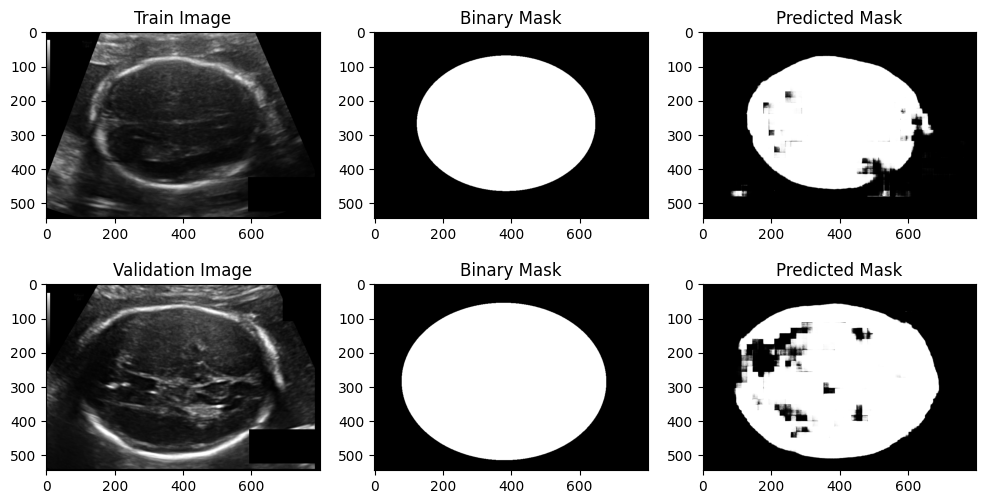

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
i = 1
fig, axs = plt.subplots(2, 3, figsize=(12,6))
axs[0,0].imshow(img_train[i][0],cmap='gray')
axs[0,0].set_title("Train Image")
axs[0,1].imshow(mask_train[i][0],cmap='gray')
axs[0,1].set_title("Binary Mask")
axs[0,2].imshow(output_train[i][0],cmap='gray')
axs[0,2].set_title("Predicted Mask")

axs[1,0].imshow(img_val[i][0],cmap='gray')
axs[1,0].set_title("Validation Image")
axs[1,1].imshow(mask_val[i][0],cmap='gray')
axs[1,1].set_title("Binary Mask")
axs[1,2].imshow(output_val[i][0],cmap='gray')
axs[1,2].set_title("Predicted Mask")

In [23]:
_,_,TestLoader = DataLoading(img_files,mask_files,test_files,200,4)
TestLoader = DeviceDataLoader(TestLoader, device)

[INFO] found 799 examples in the training set...
[INFO] found 200 examples in the val set...
[INFO] found 335 examples in the val set...


In [24]:
for test_batch in TestLoader:

    output_test = model(test_batch)

    output_test = output_test.cpu().detach().numpy()

    test_batch = test_batch.cpu().detach().numpy()
    break

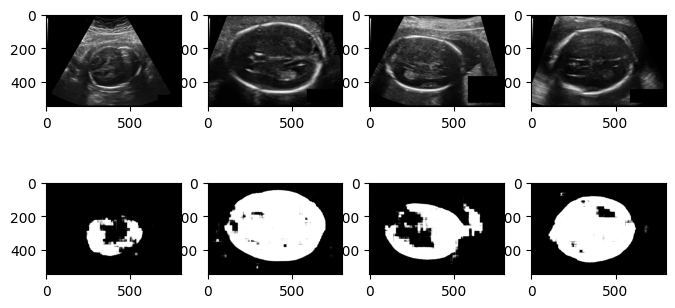

In [26]:
%matplotlib inline
fig, axs = plt.subplots(2,4, figsize=(8,4))
for i in range(len(test_batch)):
  axs[0,i].imshow(test_batch[i][0],cmap='gray')
  axs[1,i].imshow(output_test[i][0],cmap='gray')

### Training UNet Model

In [15]:
trainLoader,valLoader,testLoader = DataLoading(img_files,mask_files,test_files,200,2)

[INFO] found 799 examples in the training set...
[INFO] found 200 examples in the val set...
[INFO] found 335 examples in the val set...


In [19]:
trainLoader = DeviceDataLoader(trainLoader, device)
valLoader = DeviceDataLoader(valLoader, device)

In [20]:
UnetModel = Unet()
UnetModel = to_device(UnetModel, device)

In [21]:
Unet_history = fit(10,1e-3,UnetModel,trainLoader,valLoader)

Epoch [1], train_loss: 0.6682, val_loss: 0.6419 
 train_score: 0.6373, val_score: 0.7170
Epoch [2], train_loss: 0.6309, val_loss: 0.6584 
 train_score: 0.7962, val_score: 0.4519
Epoch [3], train_loss: 0.6211, val_loss: 0.6281 
 train_score: 0.8370, val_score: 0.7638
Epoch [4], train_loss: 0.6151, val_loss: 0.6447 
 train_score: 0.8621, val_score: 0.6023
Epoch [5], train_loss: 0.6128, val_loss: 0.6444 
 train_score: 0.8666, val_score: 0.5783
Epoch [6], train_loss: 0.6092, val_loss: 0.6401 
 train_score: 0.8807, val_score: 0.6182
Epoch [7], train_loss: 0.6040, val_loss: 0.6202 
 train_score: 0.8994, val_score: 0.7780
Epoch [8], train_loss: 0.5988, val_loss: 0.6230 
 train_score: 0.9197, val_score: 0.7532
Epoch [9], train_loss: 0.5982, val_loss: 0.6231 
 train_score: 0.9234, val_score: 0.7597
Epoch [10], train_loss: 0.5961, val_loss: 0.6112 
 train_score: 0.9310, val_score: 0.8276


In [22]:
torch.save(UnetModel.state_dict(), '/content/drive/MyDrive/UNet_Model.pt')

In [23]:
for train_batch,val_batch in zip(trainLoader,valLoader):
    img_train,mask_train = train_batch
    img_val,mask_val = val_batch

    output_train = UnetModel(img_train)
    output_val = UnetModel(img_val)

    output_train = output_train.cpu().detach().numpy()
    output_val = output_val.cpu().detach().numpy()

    img_train = img_train.cpu().detach().numpy()
    img_val = img_val.cpu().detach().numpy()

    mask_train = mask_train.cpu().detach().numpy()
    mask_val = mask_val.cpu().detach().numpy()
    break

Text(0.5, 1.0, 'Predicted Mask')

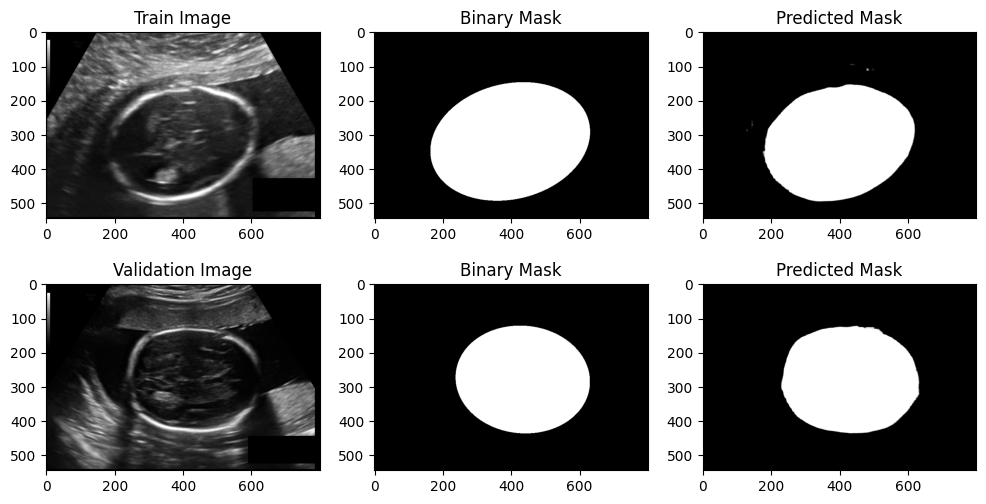

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
i = 0
fig, axs = plt.subplots(2, 3, figsize=(12,6))
axs[0,0].imshow(img_train[i][0],cmap='gray')
axs[0,0].set_title("Train Image")
axs[0,1].imshow(mask_train[i][0],cmap='gray')
axs[0,1].set_title("Binary Mask")
axs[0,2].imshow(output_train[i][0],cmap='gray')
axs[0,2].set_title("Predicted Mask")

axs[1,0].imshow(img_val[i][0],cmap='gray')
axs[1,0].set_title("Validation Image")
axs[1,1].imshow(mask_val[i][0],cmap='gray')
axs[1,1].set_title("Binary Mask")
axs[1,2].imshow(output_val[i][0],cmap='gray')
axs[1,2].set_title("Predicted Mask")

Text(0.5, 1.0, 'UNet Model Validation Set Loss')

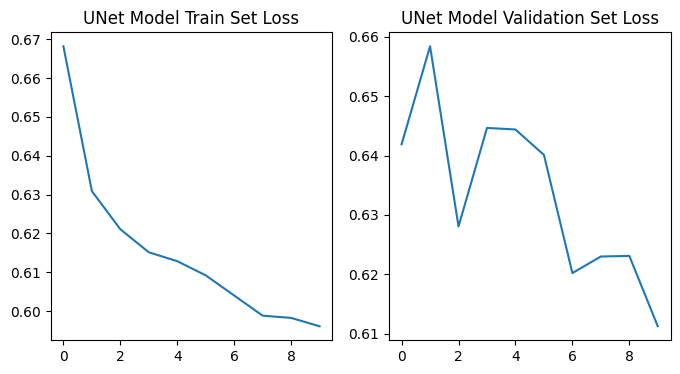

In [34]:
fig, axs = plt.subplots(1,2, figsize=(8,4))
axs[0].plot([x['train_loss'] for x in Unet_history])
axs[0].set_title('UNet Model Train Set Loss')
axs[1].plot([x['val_loss'] for x in Unet_history])
axs[1].set_title('UNet Model Validation Set Loss')

Text(0.5, 1.0, 'UNet Model Validation Set Dice Score')

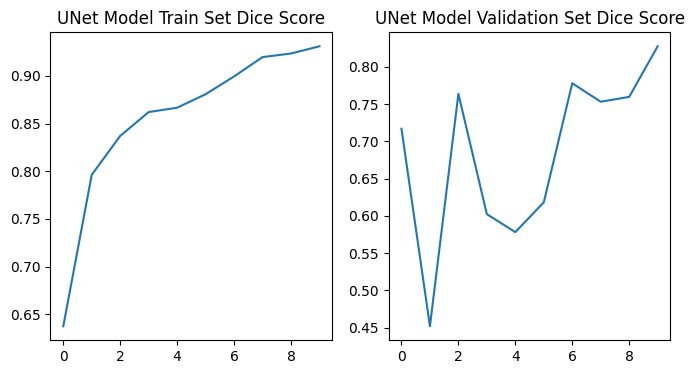

In [35]:
fig, axs = plt.subplots(1,2, figsize=(8,4))
axs[0].plot([x['train_score'] for x in Unet_history])
axs[0].set_title('UNet Model Train Set Dice Score')
axs[1].plot([x['val_score'] for x in Unet_history])
axs[1].set_title('UNet Model Validation Set Dice Score')

In [ ]:
_,_,TestLoader = DataLoading(img_files,mask_files,test_files,200,4)
TestLoader = DeviceDataLoader(TestLoader, device)

In [57]:
for test_batch in TestLoader:

    output_test = UnetModel(test_batch)

    output_test = output_test.cpu().detach().numpy()

    test_batch = test_batch.cpu().detach().numpy()
    break

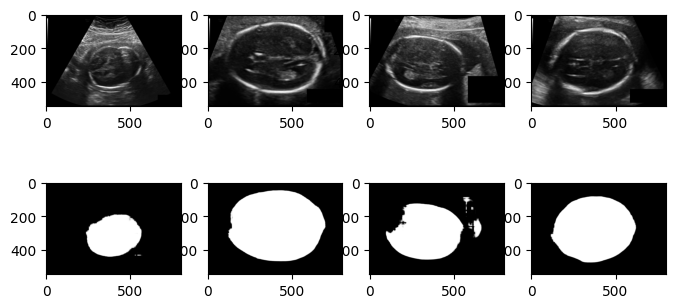

In [58]:
%matplotlib inline
fig, axs = plt.subplots(2,4, figsize=(8,4))
for i in range(len(test_batch)):
  axs[0,i].imshow(test_batch[i][0],cmap='gray')
  axs[1,i].imshow(output_test[i][0],cmap='gray')